# Extended SEIRS Community TTI Demo

**In this demonstration we will explore the effect of testing, tracing, and isolation interventions on disease transmission in the setting of an age-stratified population with a realistic contact network structured by households and work/school communities.**

This notebook provides a demonstration of the functionality of the [Extended SEIRS Network Model](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description) and the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop). This notebook also offers a sandbox for starting to explore TTI scenarios of your own. 
For a more thorough walkthrough of the model, simulation loop, and use of this package, refer to the [SEIRS+ Wiki](https://github.com/ryansmcgee/seirsplus/wiki).

### Installing and importing the model code

All of the code needed to run the model is imported from the ```models``` module of this package.

In this demo we will also use features from the `networks`, `sim_loops`, and `utilities` modules.

#### Install the package using ```pip```
The package can be installed on your machine by entering this in the command line:

```pip install seirsplus```

Then, the ```models```, `networks`, `sim_loops`, and `utilities` modules can be imported as shown here:

In [1]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot

#### *Alternatively, manually copy the code to your machine*
*You can use the model code without installing a package by copying the ```models.py``` module file to a directory on your machine. For some of the features used in this demo you will also need the `networks`, `sim_loops`, and `utilities` modules. In this case, the easiest way to use the modules is to place your scripts in the same directory as the modules, and import the modules as shown here:*
```python
from models import *
from networks import *
from sim_loops import *
from utilities import *
```

-------

## Set basic parameters

Set the total population size

In [2]:
N = 10000

Here we set the initial prevalence to be 1% of the population.

In [3]:
INIT_EXPOSED = int(N*0.01)

-------

## Specifying contact networks

This package implements models epidemic dynamics for populations with a structured [contact network](Extended-SEIRS-Model-Description#contact-networks). Individuals are represented as nodes in a network, and parameters, contacts, and interventions can be specified on a targeted individual basis. A graph specifying the contact network must be specified, where each node represents an individual in the population and edges connect individuals who have regular interactions.

This model also supports scenarios where individuals enter quarantine states in which their parameters and interactions may be different from baseline, and a separate graph defining the interactions for individuals in quarantine can be specified (i.e., the [quarantine contact network](Extended-SEIRS-Model-Description#quarantine-contacts)).

**_Note:_** *Simulation time increases with network size. Small networks simulate quickly, but have more stochastic volatility. Networks with ~10,000 are large enough to produce per-capita population dynamics that are generally consistent with those of larger networks, but small enough to simulate quickly. We recommend using networks with ~10,000 nodes for prototyping parameters and scenarios, which can then be run on larger networks if more precision is required.*

### Demographic Community Contact Network

Here we use the [**demographic community network generator**](https://github.com/ryansmcgee/seirsplus/wiki/Network-Generation#demographic-community-network) defined in the SEIRS+ package. This function generates community-level contact networks with realistic network properties as well as age-stratification, households, and communities (e.g., schools, workplaces) that are calibrated to demographic statistics for a population of interest.

Each node is assigned an age bracket (0-9, 10-19, … 70-79, 80+) according to population-level age distribution (e.g. from census data). [FARZ](https://github.com/ryansmcgee/seirsplus/wiki/network-generation#farz-networks) network layers are generated to represent the out-of-household regular contacts amongst individuals of certain age groups (i.e., children, adults, seniors). FARZ networks have a community structure, parameterized in this function such that half of an individuals connections are with members of their own community and half of their connections are with individuals from outside their own community. Separate FARZ network layers are generated for the 0-9 age group (communities can be thought of as primary schools), the 10-19 age group (communities can be thought of as secondary schools), the 20-59 age group (communities can be thought of as workplaces), and the 60+ age group. The degree distribution of these networks are broad with a heavy tail. The mean degree for each layer is calibrated to avaverage number of contacts by age group from [this study](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0050074).

Nodes are divvied up into households, such that the distribution of household sizes and the household age demographics data provided to the function. All of the nodes in a household are strongly connected, which rivots together the layers for each age group. In the SEIRS+ network models, there is also a probability *p* of well-mixed [global interactions](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) (nodes interacting with a randomly drawn node from anywhere in the network), which is an avenue for both within- and between-age-group contacts. 

We also use the `distancing_scales` argument to generate a quarantine version of the network where a majority of the out-of-household edges have been removed. The distancing scale value of `0.7` is chosen so that ~95% of individuals have no more than a single out-of-household contact (edge) in the quarantine network.

In [4]:
demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=N, demographic_data=household_country_data('US'), 
                                                            distancing_scales=[0.7], isolation_groups=[])

G_baseline   = demographic_graphs['baseline']
G_quarantine = demographic_graphs['distancingScale0.7']

households_indices = [household['indices'] for household in households]

Generated overall age distribution:
0-9: 0.1086	(-0.0124 from target)
10-19: 0.1322	(0.0012 from target)
20-29: 0.1453	(0.0083 from target)
30-39: 0.1304	(-0.0026 from target)
40-49: 0.1264	(0.0024 from target)
50-59: 0.1302	(-0.0008 from target)
60-69: 0.1169	(0.0019 from target)
70-79: 0.0733	(0.0033 from target)
80+: 0.0367	(-0.0013 from target)

Generated household size distribution:
1: 0.2769	(-0.0069 from target)
2: 0.3364	(-0.0087 from target)
3: 0.1578	(0.0071 from target)
4: 0.1312	(0.0036 from target)
5: 0.0638	(0.0060 from target)
6: 0.0238	(0.0012 from target)
7: 0.0102	(-0.0023 from target)
Num households: 4031
mean household size: 2.448393594

Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Baseline:
Degree: mean = 14.10, std = 13.58, 95% CI = (2.00, 52.00)
        coeff var = 0.96
Assortativity:    0.12
Clustering coeff: 0.25



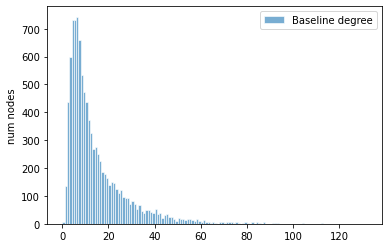

In [5]:
network_info(G_baseline, "Baseline", plot=True)

Quarantine:
Degree: mean = 2.31, std = 1.55, 95% CI = (0.00, 6.00)
        coeff var = 0.67
Assortativity:    0.95
Clustering coeff: 0.60



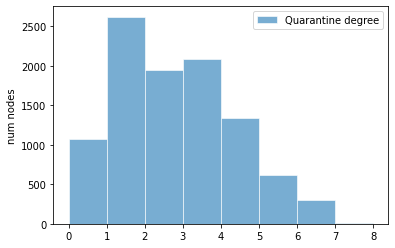

In [6]:
network_info(G_quarantine, "Quarantine", plot=True)

-------

## Specifying parameters

**_The parameter values used in this notebook reflect rough estimates of parameter values for the COVID-19 epidemic (as of 9 Aug 2020)._**

### Set disease progression rate parameters:

Parameter values are assigned to members of the population on an individual basis. Parameter values can be [specified to the `ExtSEIRSNetworkModel`](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#specifying-parameters) by providing a list of values that gives the *N* values to assign to each individual. The population may be either homogeneous or heterogeneous for a given parameter at the user's discretion. 

**Here we generate distributions of values for each parameter, and some parameter value are specified in an age-stratified manner, thus specifying a realistically heterogeneous population.**

Generate a distribution of expected latent periods (time in Exposed state) and presymptomatic periods (time in Pre-symptomatic infectious state). The `sigma` and `lamda` rates are calculated as the inverse of the expected exposed and pre-symptomatic periods assigned to each individual, respectively.

latent period:  mean = 2.21, std = 1.10, 95% CI = (0.59, 4.84)

pre-symptomatic period:  mean = 2.99, std = 1.80, 95% CI = (0.55, 7.50)

total incubation period:  mean = 5.21, std = 2.12, 95% CI = (1.95, 10.22)



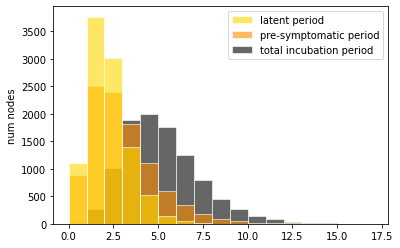

In [7]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

Generate a distribution of expected (a)symptomatic periods (time in symptomatic or asymptomatic state). The `gamma` rates are calculated as the inverse of the expected (a)symptomatic periods assigned to each individual. 

The expected total infectious period for each individual is the sum of their expected pre-symptomatic and (a)symptomatic periods.

pre-symptomatic period:  mean = 2.21, std = 1.10, 95% CI = (0.59, 4.84)

(a)symptomatic period:  mean = 4.01, std = 1.60, 95% CI = (1.51, 7.63)

total infectious period:  mean = 6.22, std = 1.93, 95% CI = (3.03, 10.63)



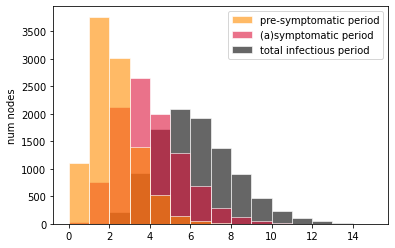

In [8]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

Generate a distribution of expected onset-to-hospitalization periods (time in symptomatic state before entering hospitalized state for those with severe cases) and hospitalization-to-discharge periods (time in hospitalized state for those with non-fatal cases). The `eta` and `gamma_H` rates are calculated as the inverse of the expected onset-to-hospitalization periods and hospitalization-to-discharge periods assigned to each individual, respectively.

onset-to-hospitalization period:  mean = 11.00, std = 4.94, 95% CI = (3.54, 22.54)

hospitalization-to-discharge period:  mean = 10.94, std = 4.96, 95% CI = (3.61, 22.57)

onset-to-discharge period:  mean = 21.94, std = 7.02, 95% CI = (10.54, 37.75)



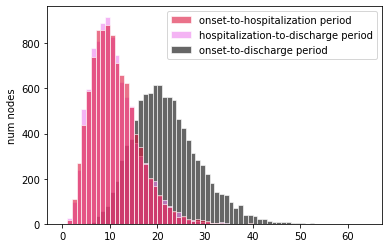

In [9]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

Generate a distribution of hospitalization-to-death periods (time in hospitalized state for those with fatal cases). The `mu_H` rates are calculated as the inverse of the expected hospitalization-to-death periods.

onset-to-hospitalization period:  mean = 11.00, std = 4.94, 95% CI = (3.54, 22.54)

hospitalization-to-death period:  mean = 6.99, std = 3.16, 95% CI = (2.22, 14.45)

onset-to-death period:  mean = 18.00, std = 5.87, 95% CI = (8.46, 31.15)



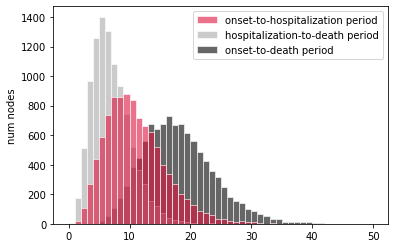

In [10]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

### Set severity parameters

Specify the percentage of cases that are asymptomatic. This percentage of case will progress from the pre-symptomatic state to the asymptomatic state, rather than to the symptomatic state.

In [11]:
PCT_ASYMPTOMATIC = 0.25

Here we age-stratify our definition of asymptomatic rate by setting the percent of asymptomatic cases for children to be 80% while the rest of the adult population remains set at 25%.

The `individual_ageGroups` variable is returned by the [`generate_demographic_contact_network()` function](https://github.com/ryansmcgee/seirsplus/wiki/Network-generation#demographic-community-network) and holds a list of the age group labels assigned to each individual. This is useful for assigning parameters in an age-group-dependent way as we do for the following severity parameters.

In [12]:
PCT_ASYMPTOMATIC = [0.8 if age in ['0-9', '10-19'] else PCT_ASYMPTOMATIC for age in individual_ageGroups]

Here we specify age-stratified case hospitalization rates using rates taken from [Verity et al. (2020)](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext).

In [13]:
ageGroup_pctHospitalized = {'0-9':      0.0000,
                            '10-19':    0.0004,
                            '20-29':    0.0104,
                            '30-39':    0.0343,
                            '40-49':    0.0425,
                            '50-59':    0.0816,
                            '60-69':    0.118,
                            '70-79':    0.166,
                            '80+':      0.184 }
PCT_HOSPITALIZED = [ageGroup_pctHospitalized[ageGroup] for ageGroup in individual_ageGroups]

Here we specify fatality rates for hospitalized cases, again using rates taken from [Verity et al. (2020)](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext).

In [14]:
ageGroup_hospitalFatalityRate = {'0-9':     0.0000,
                                 '10-19':   0.3627,
                                 '20-29':   0.0577,
                                 '30-39':   0.0426,
                                 '40-49':   0.0694,
                                 '50-59':   0.1532,
                                 '60-69':   0.3381,
                                 '70-79':   0.5187,
                                 '80+':     0.7283 }
PCT_FATALITY = [ageGroup_hospitalFatalityRate[ageGroup] for ageGroup in individual_ageGroups]

### Set transmission parameters

The [Extended SEIRS Network Model](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#stochastic-network-model-implementation) model considers two modes of disease transmission: a well-mixed mode of [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) and a contact network based mode of [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission). The propensity for a given individual to become exposed due to global transmission depends on the mean transmissibility of all infectious individuals in the population; the propensity for a given individual to become exposed due to local transmission depends on the pairwise transmissibilities between the focal node and its infectious contacts in the network (see [Transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#transmission) and [Model Equations](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#model-equations) for more information about these calculations). 

The transmissibility parameter *β* can be related to the basic reproduction number *R<sub>0</sub>* (i.e., the expected number of new infections generated by a single infectious individual in a completely susceptible population) by the standard formula: *β = R<sub>0</sub>𝛾*. *R<sub>0</sub>* is a more interpretable parameter, so we specify transmissibility in terms of *R<sub>0</sub>* and then calculate the corresponding *β* values.

First, we generate a distribution of individual *R<sub>0</sub>* values (i.e., the expected number of new infections generated by a single *particular* infectious individual in a completely susceptible population). Of course, this means that transmissibility is heterogeneous in this population. The coefficient of variation is an important parameter for the individual *R<sub>0</sub>* distribution in that it tunes the degree of superspreading in the heterogeneous transmissibility. The distribution used in this example has a relatively low coefficient of variation, so most individuals have around the same degree of transmissibility. But a higher coefficient of variation (e.g., 2.0) would give a long right tail in idividual transmissibility representing a small number of individuals contributing many cases while the majority cases contribute less than 1 on average when they are infectious.

Individual R0:  mean = 2.50, std = 0.50, 95% CI = (1.61, 3.58)



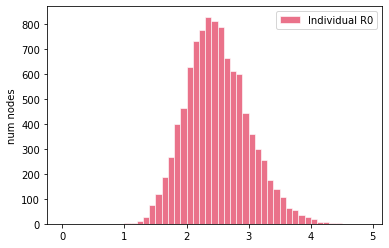

In [15]:
R0_mean     = 2.5
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, N)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

Individuals are ultimately assigned an [*Individual Transmissibility Value*](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#transmissibility-parameters) (*β<sup>i</sup>*), which are stored in the `beta` attribute of the model object. 

The means of the Individual Transmissibility Values for infectious subpopulations are used to calculate the [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) terms. Individual Transmissibility Values may also be used to generate the Pairwise Transmissibility Values used for [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission) terms, as we will specify in a few steps.

In [16]:
BETA = 1/infectiousPeriod * R0

Individuals can be assigned different Individual Transmissibility Values for use when they are asymptomatic and quarantine states. 

Here we set the transmissibility of quarantined individuals such that the mean effective reproduction number for quarantined individuals is about 0.3. This supposes that individuals have different behavior, hygiene, etc. when they are quarantining relative to baseline.

In [17]:
BETA_Q = BETA * (0.3/R0_mean)

Now we specify how we would like the [*Pairwise Transmissibility Values*](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#transmissibility-parameters) (*β<sup>i</sup>*), which define the local transmissibility for each pair of close contacts, to be calculated. There are [multiple ways to specify these pairwise transmissibilities](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#pairwise-transmissibility-values) (such as providing a matrix), but here we will set the `beta_pairwise_mode` argument of the `ExtSEIRSNetworkModel` constructor to `'infected'`, which will direct the model to automatically generate a matrix of Pairwise Transmissibility Values such that the transmissibility of each infectious-susceptible interaction is equal to the infected individual's transmissiblity.

In [18]:
BETA_PAIRWISE_MODE  = 'infected'

Here we designate that we would like the model to automatically calculate [Connectivity Correction Factors](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#connectivity-correction-factor) for each pair of interacting close contacts. This pairwise factor is optional, but it can be used to weight the transmissibility of interactions according to the connectivity of the interacting individuals. Here we choose to weight interactions according to a ratio of the pair's mean degree to the population's mean degree (see [Specifying connectivity Correction Factors](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#connectivity-correction-factors) for more information). 

Using this definition, when two individuals whose average degree is an order of magnitude greater than the average degree of the population overall, then the propensity of exposure in their interaction is weighted to be twice that of two averagely-connected individuals. 

In [19]:
DELTA_PAIRWISE_MODE = 'mean'

Here we set individual susceptibilities (default susceptibility is 1). 

In particular, we specify that children are half as susceptible as adults.

In [20]:
ALPHA = [0.5 if age in ['0-9', '10-19'] else 1.0 for age in individual_ageGroups]

In the stochastic network model, an individual comes into contact with a random individual from the population at large (e.g., in a public space) with probability *p* or with an individual from their set of close contacts with probability *(1-p)*. Transmission that occurs between an individual and the population at large is referred to as [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission), and transmission between an individual and one of their close contacts (network neighbors) is referred to as [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission). The parameter *p* defines the locality of the network: for *p=0* an individual only interacts with their close contacts, while *p=1* represents a uniformly mixed population.

Here we set *p* to reflect 20% of interactions being with incidental or casual contacts outside their set of close contacts.

In [21]:
P_GLOBALINTXN = 0.2

The parameter *q* (down)weights the rate of interactions with the population at large while one is in quarantine relative to baseline.

Here we set *q* to 0.05, which supposes that global interactions are quite rare (but nonzero) for quarantined individuals.

In [22]:
Q_GLOBALINTXN = 0.05

### Set Testing, Tracing, & Isolation (TTI) intervention protocol parameters:

Here we specify the parameters that govern the Testing, Tracing, and Isolation protocol that is implemented by the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop). The implementation of this TTI protocol and the interpretation of these parameters is desribed in detail on the [TTI Simulation Loop wiki page](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop) (but these parameters are briefly explained as code comments below).

In [23]:
INTERVENTION_START_PCT_INFECTED = 1/100
AVERAGE_INTRODUCTIONS_PER_DAY   = 0

TESTING_CADENCE                 = 'everyday'    # how often to do tracing testing and random testing
PCT_TESTED_PER_DAY              = 1/10          # max daily test allotment defined as a percent of population size
TEST_FALSENEG_RATE              = 'temporal'    # test false negative rate, will use FN rate that varies with disease time
MAX_PCT_TESTS_FOR_SYMPTOMATICS  = 1.0           # max percent of daily test allotment to use on self-reporting symptomatics
MAX_PCT_TESTS_FOR_TRACES        = 1.0           # max percent of daily test allotment to use on contact traces
RANDOM_TESTING_DEGREE_BIAS      = 0             # magnitude of degree bias in random selections for testing, none here

PCT_CONTACTS_TO_TRACE           = 0.5           # percentage of primary cases' contacts that are traced
TRACING_LAG                     = 2             # number of cadence testing days between primary tests and tracing tests

ISOLATION_LAG_SYMPTOMATIC       = 1             # number of days between onset of symptoms and self-isolation of symptomatics
ISOLATION_LAG_POSITIVE          = 2             # test turn-around time (TAT): number of days between administration of test and isolation of positive cases
ISOLATION_LAG_CONTACT           = 0             # number of days between a contact being traced and that contact self-isolating


### Set intervention compliance parameters

First, we specify the compliance rates (i.e., the percentage of individuals who are compliant) for each intervention type. See the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop) documentation for more information about compliance.

In [24]:
TESTING_COMPLIANCE_RATE_SYMPTOMATIC                  = 0.5
TESTING_COMPLIANCE_RATE_TRACED                       = 1.0
TESTING_COMPLIANCE_RATE_RANDOM                       = 0.8

TRACING_COMPLIANCE_RATE                              = 0.8

ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL     = 0.3
ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE      = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL        = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE         = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT           = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE  = 0.0

Now, we randomly assign a `True/False` compliance to each individual according to the rates set above. Individuals whose compliance is set to `True` for a given intervention will participate in that intervention, individuals set to `False` will not.

In [25]:
TESTING_COMPLIANCE_RANDOM                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_RANDOM)
TESTING_COMPLIANCE_TRACED                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_TRACED)
TESTING_COMPLIANCE_SYMPTOMATIC                   = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_SYMPTOMATIC)

TRACING_COMPLIANCE                               = (numpy.random.rand(N) < TRACING_COMPLIANCE_RATE)

ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL      = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL)
ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE       = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL         = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL)
ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE          = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_CONTACT            = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT)
ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE   = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE)

-------

## Initializing the model

In [26]:
model = ExtSEIRSNetworkModel(G=G_baseline, p=P_GLOBALINTXN,
                              beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                              gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                              a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                              alpha=ALPHA, beta_pairwise_mode=BETA_PAIRWISE_MODE, delta_pairwise_mode=DELTA_PAIRWISE_MODE,
                              G_Q=G_quarantine, q=0, beta_Q=BETA_Q, isolation_time=14,
                              initE=INIT_EXPOSED)

/usr/local/lib/python3.8/site-packages/seirsplus/models.py:2965: RuntimeWarning: divide by zero encountered in log
  self.delta               = numpy.log(self.degree)/numpy.log(numpy.mean(self.degree))     if self.parameters['delta'] is None   else numpy.array(self.parameters['delta'])   if isinstance(self.parameters['delta'], (list, numpy.ndarray))   else numpy.full(fill_value=self.parameters['delta'], shape=(self.numNodes,1))
/usr/local/lib/python3.8/site-packages/seirsplus/models.py:2966: RuntimeWarning: divide by zero encountered in log
  self.delta_Q             = numpy.log(self.degree_Q)/numpy.log(numpy.mean(self.degree_Q)) if self.parameters['delta_Q'] is None else numpy.array(self.parameters['delta_Q']) if isinstance(self.parameters['delta_Q'], (list, numpy.ndarray)) else numpy.full(fill_value=self.parameters['delta_Q'], shape=(self.numNodes,1))


-------

## Running the model

Set the max simulation time to 300 days.

In [27]:
T = 300

Execute the TTI simulation scenario by calling the `run_tti_sim()` function, which runs a custom simulation loop that implements the [TTI Simulation Protocol](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop).

In [28]:
run_tti_sim(model, T, 
            intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED, average_introductions_per_day=AVERAGE_INTRODUCTIONS_PER_DAY,
            testing_cadence=TESTING_CADENCE, pct_tested_per_day=PCT_TESTED_PER_DAY, test_falseneg_rate=TEST_FALSENEG_RATE, 
            testing_compliance_symptomatic=TESTING_COMPLIANCE_SYMPTOMATIC, max_pct_tests_for_symptomatics=MAX_PCT_TESTS_FOR_SYMPTOMATICS,
            testing_compliance_traced=TESTING_COMPLIANCE_TRACED, max_pct_tests_for_traces=MAX_PCT_TESTS_FOR_TRACES,
            testing_compliance_random=TESTING_COMPLIANCE_RANDOM, random_testing_degree_bias=RANDOM_TESTING_DEGREE_BIAS,
            tracing_compliance=TRACING_COMPLIANCE, pct_contacts_to_trace=PCT_CONTACTS_TO_TRACE, tracing_lag=TRACING_LAG,
            isolation_compliance_symptomatic_individual=ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL, isolation_compliance_symptomatic_groupmate=ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE, 
            isolation_compliance_positive_individual=ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL, isolation_compliance_positive_groupmate=ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE,
            isolation_compliance_positive_contact=ISOLATION_COMPLIANCE_POSITIVE_CONTACT, isolation_compliance_positive_contactgroupmate=ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE,
            isolation_lag_symptomatic=ISOLATION_LAG_SYMPTOMATIC, isolation_lag_positive=ISOLATION_LAG_POSITIVE, isolation_groups=households_indices)

[INTERVENTIONS @ t = 0.08 (100 (1.00%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 0 positive (0.00 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	0	will isolate due to positive test    (0 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 1.00 (106 (1.06%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	999	tested randomly         [+ 4 positive (0.40 %) +]
	1000	tested TOTAL            [+ 5 positive (0.50 %) +]
	2	will isolate due to symptoms         (0 as groupmates of symptomatic)
	5	will isolate due to positive test    (9 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolati

[INTERVENTIONS @ t = 17.01 (272 (2.72%) infected)]
	7	tested due to symptoms  [+ 6 positive (85.71 %) +]
	66	tested as traces        [+ 4 positive (6.06 %) +]
	927	tested randomly         [+ 6 positive (0.65 %) +]
	1000	tested TOTAL            [+ 16 positive (1.60 %) +]
	7	will isolate due to symptoms         (0 as groupmates of symptomatic)
	16	will isolate due to positive test    (29 as groupmates of positive)
	63	will isolate due to positive contact (0 as groupmates of contact)
	109 entered isolation
[INTERVENTIONS @ t = 18.01 (269 (2.69%) infected)]
	2	tested due to symptoms  [+ 2 positive (100.00 %) +]
	64	tested as traces        [+ 4 positive (6.25 %) +]
	934	tested randomly         [+ 8 positive (0.86 %) +]
	1000	tested TOTAL            [+ 14 positive (1.40 %) +]
	9	will isolate due to symptoms         (0 as groupmates of symptomatic)
	14	will isolate due to positive test    (24 as groupmates of positive)
	47	will isolate due to positive contact (0 as groupmates of contact)
	97 

[INTERVENTIONS @ t = 34.03 (279 (2.79%) infected)]
	6	tested due to symptoms  [+ 5 positive (83.33 %) +]
	90	tested as traces        [+ 2 positive (2.22 %) +]
	904	tested randomly         [+ 7 positive (0.77 %) +]
	1000	tested TOTAL            [+ 14 positive (1.40 %) +]
	12	will isolate due to symptoms         (0 as groupmates of symptomatic)
	14	will isolate due to positive test    (28 as groupmates of positive)
	80	will isolate due to positive contact (0 as groupmates of contact)
	144 entered isolation
[INTERVENTIONS @ t = 35.01 (277 (2.77%) infected)]
	5	tested due to symptoms  [+ 4 positive (80.00 %) +]
	74	tested as traces        [+ 7 positive (9.46 %) +]
	921	tested randomly         [+ 6 positive (0.65 %) +]
	1000	tested TOTAL            [+ 17 positive (1.70 %) +]
	8	will isolate due to symptoms         (0 as groupmates of symptomatic)
	17	will isolate due to positive test    (36 as groupmates of positive)
	64	will isolate due to positive contact (0 as groupmates of contact)
	98 

[INTERVENTIONS @ t = 51.00 (274 (2.74%) infected)]
	2	tested due to symptoms  [+ 2 positive (100.00 %) +]
	81	tested as traces        [+ 3 positive (3.70 %) +]
	917	tested randomly         [+ 8 positive (0.87 %) +]
	1000	tested TOTAL            [+ 13 positive (1.30 %) +]
	6	will isolate due to symptoms         (0 as groupmates of symptomatic)
	13	will isolate due to positive test    (18 as groupmates of positive)
	89	will isolate due to positive contact (0 as groupmates of contact)
	142 entered isolation
[INTERVENTIONS @ t = 52.01 (280 (2.80%) infected)]
	8	tested due to symptoms  [+ 7 positive (87.50 %) +]
	126	tested as traces        [+ 9 positive (7.14 %) +]
	866	tested randomly         [+ 4 positive (0.46 %) +]
	1000	tested TOTAL            [+ 20 positive (2.00 %) +]
	10	will isolate due to symptoms         (0 as groupmates of symptomatic)
	20	will isolate due to positive test    (33 as groupmates of positive)
	122	will isolate due to positive contact (0 as groupmates of contact)
	

[INTERVENTIONS @ t = 68.00 (275 (2.75%) infected)]
	10	tested due to symptoms  [+ 8 positive (80.00 %) +]
	44	tested as traces        [+ 2 positive (4.55 %) +]
	946	tested randomly         [+ 9 positive (0.95 %) +]
	1000	tested TOTAL            [+ 19 positive (1.90 %) +]
	4	will isolate due to symptoms         (0 as groupmates of symptomatic)
	19	will isolate due to positive test    (39 as groupmates of positive)
	42	will isolate due to positive contact (0 as groupmates of contact)
	76 entered isolation
[INTERVENTIONS @ t = 69.01 (269 (2.69%) infected)]
	6	tested due to symptoms  [+ 6 positive (100.00 %) +]
	80	tested as traces        [+ 1 positive (1.25 %) +]
	914	tested randomly         [+ 12 positive (1.31 %) +]
	1000	tested TOTAL            [+ 19 positive (1.90 %) +]
	10	will isolate due to symptoms         (0 as groupmates of symptomatic)
	19	will isolate due to positive test    (34 as groupmates of positive)
	87	will isolate due to positive contact (0 as groupmates of contact)
	1

[INTERVENTIONS @ t = 85.01 (169 (1.69%) infected)]
	7	tested due to symptoms  [+ 6 positive (85.71 %) +]
	51	tested as traces        [+ 2 positive (3.92 %) +]
	942	tested randomly         [+ 6 positive (0.64 %) +]
	1000	tested TOTAL            [+ 14 positive (1.40 %) +]
	4	will isolate due to symptoms         (0 as groupmates of symptomatic)
	14	will isolate due to positive test    (43 as groupmates of positive)
	48	will isolate due to positive contact (0 as groupmates of contact)
	102 entered isolation
[INTERVENTIONS @ t = 86.07 (172 (1.72%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	107	tested as traces        [+ 4 positive (3.74 %) +]
	892	tested randomly         [+ 5 positive (0.56 %) +]
	1000	tested TOTAL            [+ 10 positive (1.00 %) +]
	5	will isolate due to symptoms         (0 as groupmates of symptomatic)
	10	will isolate due to positive test    (30 as groupmates of positive)
	101	will isolate due to positive contact (0 as groupmates of contact)
	1

[INTERVENTIONS @ t = 102.01 (112 (1.12%) infected)]
	3	tested due to symptoms  [+ 3 positive (100.00 %) +]
	24	tested as traces        [+ 0 positive (0.00 %) +]
	973	tested randomly         [+ 3 positive (0.31 %) +]
	1000	tested TOTAL            [+ 6 positive (0.60 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	6	will isolate due to positive test    (17 as groupmates of positive)
	27	will isolate due to positive contact (0 as groupmates of contact)
	42 entered isolation
[INTERVENTIONS @ t = 103.04 (105 (1.05%) infected)]
	1	tested due to symptoms  [+ 0 positive (0.00 %) +]
	1	tested as traces        [+ 0 positive (0.00 %) +]
	998	tested randomly         [+ 8 positive (0.80 %) +]
	1000	tested TOTAL            [+ 8 positive (0.80 %) +]
	5	will isolate due to symptoms         (0 as groupmates of symptomatic)
	8	will isolate due to positive test    (19 as groupmates of positive)
	2	will isolate due to positive contact (0 as groupmates of contact)
	7 entered

[INTERVENTIONS @ t = 119.02 (65 (0.65%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	20	tested as traces        [+ 2 positive (10.00 %) +]
	980	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 2 positive (0.20 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	2	will isolate due to positive test    (6 as groupmates of positive)
	25	will isolate due to positive contact (0 as groupmates of contact)
	45 entered isolation
[INTERVENTIONS @ t = 120.01 (68 (0.68%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	60	tested as traces        [+ 0 positive (0.00 %) +]
	939	tested randomly         [+ 3 positive (0.32 %) +]
	1000	tested TOTAL            [+ 4 positive (0.40 %) +]
	2	will isolate due to symptoms         (0 as groupmates of symptomatic)
	4	will isolate due to positive test    (8 as groupmates of positive)
	53	will isolate due to positive contact (0 as groupmates of contact)
	63 entered

[INTERVENTIONS @ t = 136.10 (47 (0.47%) infected)]
	2	tested due to symptoms  [+ 2 positive (100.00 %) +]
	8	tested as traces        [+ 0 positive (0.00 %) +]
	990	tested randomly         [+ 5 positive (0.51 %) +]
	1000	tested TOTAL            [+ 7 positive (0.70 %) +]
	2	will isolate due to symptoms         (0 as groupmates of symptomatic)
	7	will isolate due to positive test    (20 as groupmates of positive)
	7	will isolate due to positive contact (0 as groupmates of contact)
	12 entered isolation
[INTERVENTIONS @ t = 137.31 (49 (0.49%) infected)]
	1	tested due to symptoms  [+ 0 positive (0.00 %) +]
	13	tested as traces        [+ 0 positive (0.00 %) +]
	986	tested randomly         [+ 3 positive (0.30 %) +]
	1000	tested TOTAL            [+ 3 positive (0.30 %) +]
	2	will isolate due to symptoms         (0 as groupmates of symptomatic)
	3	will isolate due to positive test    (7 as groupmates of positive)
	11	will isolate due to positive contact (0 as groupmates of contact)
	16 entered i

[INTERVENTIONS @ t = 154.00 (34 (0.34%) infected)]
	3	tested due to symptoms  [+ 2 positive (66.67 %) +]
	12	tested as traces        [+ 0 positive (0.00 %) +]
	985	tested randomly         [+ 1 positive (0.10 %) +]
	1000	tested TOTAL            [+ 3 positive (0.30 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	3	will isolate due to positive test    (6 as groupmates of positive)
	17	will isolate due to positive contact (0 as groupmates of contact)
	20 entered isolation
[INTERVENTIONS @ t = 155.02 (35 (0.35%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 1 positive (0.10 %) +]
	1000	tested TOTAL            [+ 1 positive (0.10 %) +]
	3	will isolate due to symptoms         (0 as groupmates of symptomatic)
	1	will isolate due to positive test    (0 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	2 entered iso

[INTERVENTIONS @ t = 172.07 (28 (0.28%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 0 positive (0.00 %) +]
	2	will isolate due to symptoms         (0 as groupmates of symptomatic)
	0	will isolate due to positive test    (0 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	3 entered isolation
[INTERVENTIONS @ t = 173.00 (30 (0.30%) infected)]
	3	tested due to symptoms  [+ 3 positive (100.00 %) +]
	12	tested as traces        [+ 1 positive (8.33 %) +]
	985	tested randomly         [+ 3 positive (0.30 %) +]
	1000	tested TOTAL            [+ 7 positive (0.70 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	7	will isolate due to positive test    (7 as groupmates of positive)
	16	will isolate due to positive contact (0 as groupmates of contact)
	22 entered is

[INTERVENTIONS @ t = 189.14 (20 (0.20%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	999	tested randomly         [+ 1 positive (0.10 %) +]
	1000	tested TOTAL            [+ 2 positive (0.20 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	2	will isolate due to positive test    (3 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 190.42 (20 (0.20%) infected)]
	2	tested due to symptoms  [+ 1 positive (50.00 %) +]
	7	tested as traces        [+ 0 positive (0.00 %) +]
	991	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 1 positive (0.10 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	1	will isolate due to positive test    (0 as groupmates of positive)
	13	will isolate due to positive contact (0 as groupmates of contact)
	23 entered iso

[INTERVENTIONS @ t = 206.01 (15 (0.15%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 1 positive (0.10 %) +]
	1000	tested TOTAL            [+ 1 positive (0.10 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	1	will isolate due to positive test    (2 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	1 entered isolation
[INTERVENTIONS @ t = 207.13 (12 (0.12%) infected)]
	1	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	999	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 0 positive (0.00 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	0	will isolate due to positive test    (0 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolati

[INTERVENTIONS @ t = 226.11 (14 (0.14%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 1 positive (0.10 %) +]
	1000	tested TOTAL            [+ 1 positive (0.10 %) +]
	1	will isolate due to symptoms         (0 as groupmates of symptomatic)
	1	will isolate due to positive test    (1 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 227.43 (12 (0.12%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	999	tested randomly         [+ 2 positive (0.20 %) +]
	1000	tested TOTAL            [+ 3 positive (0.30 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	3	will isolate due to positive test    (8 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	1 entered isola

[INTERVENTIONS @ t = 243.05 (20 (0.20%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	999	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 1 positive (0.10 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	1	will isolate due to positive test    (1 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	1 entered isolation
[INTERVENTIONS @ t = 244.06 (26 (0.26%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	4	tested as traces        [+ 0 positive (0.00 %) +]
	996	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 0 positive (0.00 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	0	will isolate due to positive test    (0 as groupmates of positive)
	4	will isolate due to positive contact (0 as groupmates of contact)
	8 entered isolat

[INTERVENTIONS @ t = 262.22 (17 (0.17%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	999	tested randomly         [+ 1 positive (0.10 %) +]
	1000	tested TOTAL            [+ 2 positive (0.20 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	2	will isolate due to positive test    (10 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 263.89 (17 (0.17%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	1	tested as traces        [+ 0 positive (0.00 %) +]
	998	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 1 positive (0.10 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	1	will isolate due to positive test    (2 as groupmates of positive)
	1	will isolate due to positive contact (0 as groupmates of contact)
	3 entered iso

[INTERVENTIONS @ t = 286.00 (0 (0.00%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 0 positive (0.00 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	0	will isolate due to positive test    (0 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 287.00 (0 (0.00%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 0 positive (0.00 %) +]
	1000	tested TOTAL            [+ 0 positive (0.00 %) +]
	0	will isolate due to symptoms         (0 as groupmates of symptomatic)
	0	will isolate due to positive test    (0 as groupmates of positive)
	0	will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolatio

(0.07861509837720071, 288.2946630705424)

In [29]:
results_summary(model)

total percent infected: 30.05%
total percent fatality: 0.54%
peak  pct hospitalized: 0.17%


-------

## Visualizing the results

/usr/local/lib/python3.8/site-packages/seirsplus/models.py:3913: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


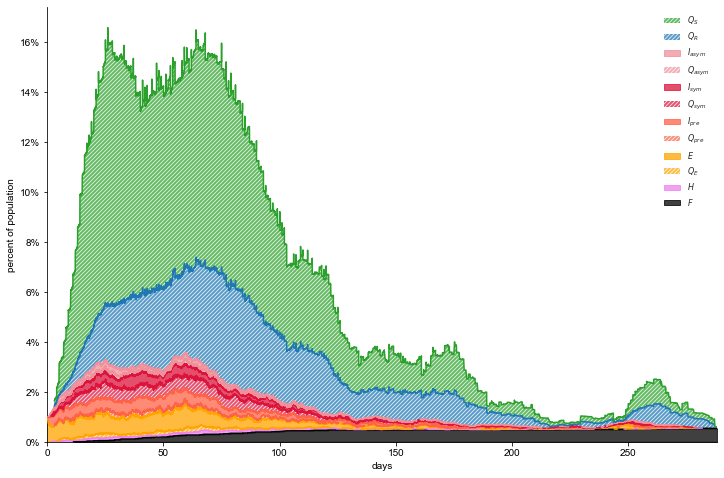

In [30]:
fig, ax = model.figure_infections(combine_Q_infected=False, plot_Q_R='stacked', plot_Q_S='stacked')